In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner

from sklearn.model_selection import train_test_split

In [53]:
FEATURES_DATE_TO = 102
TEST_DATE_TO = 250
CAMPAIGN_DURATION = 30
PRICE = 80
COST_PRICE = 52
COMMUNICATION_COST = 1
MARGIN_RATE = (PRICE-COST_PRICE)/PRICE


def compute_receipts_features(receipts: pd.DataFrame,
                              date_to: int,
                              num_days: int,) -> pd.DataFrame:
    date_from = date_to - num_days
    date_mask = (receipts['date'] >= date_from) & (receipts['date'] < date_to)

    features = (receipts.loc[date_mask].groupby(by=['customer_id']).agg({
        "purchase_amt": ["count", "sum", "max", "min", "mean", "median"],
        "purchase_sum": ["sum", "max", "min", "mean", "median"],
        "date": ["min", "max"],
        "discount": ["sum"]}
    )
        .assign(mean_time_interval=lambda d: (
            (d['date']['max'] - d['date']['min'])
            / (d['purchase_amt']['count'] - 1))
    )
        .assign(time_since_last=lambda d: (
            date_to - d['date']['max'])
    )
        .assign(lifetime=lambda d: (
            date_to - d['date']['min'])
    )
        .assign(lifetime_purchase_sum=lambda d: (
            (d['date']['max'] - d['date']['min'])
            / (d['purchase_sum']['sum'] - 1))
    )
        .assign(lifetime_purchase_amt=lambda d: (
            (d['date']['max'] - d['date']['min'])
            / (d['purchase_amt']['sum'] - 1))
    ))

    column_names = [
        f'{col}__{agg}__{num_days}d' if agg else f'{col}__{num_days}d'
        for col, agg in features.columns
    ]
    features.columns = column_names
    features.reset_index(inplace=True)

    return features


def _prepare_data(receipts: pd.DataFrame,
                  campaign_results: pd.DataFrame,
                  customers: pd.DataFrame,
                  features_date_to: int = FEATURES_DATE_TO) -> pd.DataFrame:

    result_parts = [
        compute_receipts_features(receipts, features_date_to, num_days=7),
        compute_receipts_features(receipts, features_date_to, num_days=14),
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=90),
        customers,
    ]

    result = campaign_results.copy()
    for part in result_parts:
        result = result.merge(part, on='customer_id', how='left')

    return result


def _prepare_test_data(receipts: pd.DataFrame,
                       customers: pd.DataFrame,
                       features_date_to: int = FEATURES_DATE_TO) -> pd.DataFrame:

    result_parts = [
        customers,
        compute_receipts_features(receipts, features_date_to, num_days=7),
        compute_receipts_features(receipts, features_date_to, num_days=14),
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=90),
    ]

    result = result_parts[0]
    for part in result_parts[1:]:
        result = result.merge(part, on='customer_id', how='left')

    return result

In [54]:
campaigns = pd.read_csv('campaigns.csv', index_col = 0)
customers = pd.read_csv('customers.csv', index_col = 0)
receipts = pd.read_parquet('receipts.parquet')

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [55]:
campaigns.head()

,customer_id,n_offer_days,date,target_group_flag
0,0,7,102,1
1,1,7,102,1
2,2,7,102,1
3,3,7,102,1
4,4,7,102,1


In [56]:
customers.head()

,customer_id,age,location
0,0,56,Oxenfurt
1,1,53,Hindarsfjall
2,2,41,Hindarsfjall
3,3,60,Kaer_Trolde
4,4,22,Spikeroog


In [57]:
receipts.head()

,customer_id,date,purchase_amt,discount,purchase_sum
26,26,0,12.125273,0,970.021866
53,53,0,34.357035,0,2748.562788
56,56,0,8.695825,0,695.666022
58,58,0,28.299046,0,2263.923641
64,64,0,32.547511,0,2603.800857


In [58]:
campaigns.date.unique()

array([102])

In [59]:
all_customers = set(customers.customer_id.unique())
target_customers = set(campaigns.customer_id.unique())
not_target_customers = all_customers.difference(target_customers)
control_customers = set(np.random.choice(
    list(not_target_customers), size=len(target_customers), replace=False))

print(len(all_customers))

2000000


In [60]:
target_cols = ['target_purchases_count', 'target_purchases_sum',
               'target_campaign_points_spent', 'target_purchases_amt_sum']

In [61]:
campaign_results = (
    compute_receipts_features(
        receipts, 102+CAMPAIGN_DURATION, num_days=CAMPAIGN_DURATION)
    .rename(columns={f'purchase_amt__count__{CAMPAIGN_DURATION}d': 'target_purchases_count',
                     f'purchase_amt__sum__{CAMPAIGN_DURATION}d': 'target_purchases_amt_sum',
                     f'purchase_sum__sum__{CAMPAIGN_DURATION}d': 'target_purchases_sum',
                     f'discount__sum__{CAMPAIGN_DURATION}d': 'target_campaign_points_spent',
                     })
    [['customer_id']+target_cols]
    .merge(customers[['customer_id']], how='right')
    .fillna(0)
)

campaign_results['treatment_flg'] = 0
campaign_results.loc[campaign_results.customer_id.isin(
    target_customers), 'treatment_flg'] = 1

campaign_results.shape

(2000000, 6)

In [62]:
campaign_results

,customer_id,target_purchases_count,target_purchases_sum,target_campaign_points_spent,target_purchases_amt_sum,treatment_flg
0,0,3.0,2538.766684,40.0,31.734584,1
1,1,3.0,2520.087704,0.0,31.501096,1
2,2,2.0,4199.119407,0.0,52.488993,1
3,3,4.0,7573.037092,40.0,94.662964,1
4,4,1.0,1033.298545,0.0,12.916232,1
...,...,...,...,...,...,...
1999995,1999995,4.0,5507.435329,0.0,68.842942,0
1999996,1999996,2.0,2816.385346,0.0,35.204817,0
1999997,1999997,2.0,2032.834283,0.0,25.410429,0
1999998,1999998,0.0,0.000000,0.0,0.000000,0


In [63]:
campaign_results = _prepare_data(receipts,
                                 campaign_results,
                                 customers,
                                 )

In [64]:
campaign_results

,customer_id,target_purchases_count,target_purchases_sum,target_campaign_points_spent,target_purchases_amt_sum,treatment_flg,purchase_amt__count__7d,purchase_amt__sum__7d,purchase_amt__max__7d,purchase_amt__min__7d,...,date__min__90d,date__max__90d,discount__sum__90d,mean_time_interval__90d,time_since_last__90d,lifetime__90d,lifetime_purchase_sum__90d,lifetime_purchase_amt__90d,age,location
0,0,3.0,2538.766684,40.0,31.734584,1,NaN,NaN,NaN,NaN,...,18.0,93.0,0.0,8.333333,9.0,84.0,0.009058,0.731627,56,Oxenfurt
1,1,3.0,2520.087704,0.0,31.501096,1,NaN,NaN,NaN,NaN,...,16.0,82.0,0.0,13.200000,20.0,86.0,0.011679,0.947588,53,Hindarsfjall
2,2,2.0,4199.119407,0.0,52.488993,1,2.0,39.133650,34.363092,4.770558,...,17.0,100.0,0.0,13.833333,2.0,85.0,0.006316,0.508338,41,Hindarsfjall
3,3,4.0,7573.037092,40.0,94.662964,1,NaN,NaN,NaN,NaN,...,16.0,78.0,0.0,10.333333,24.0,86.0,0.004510,0.362903,60,Kaer_Trolde
4,4,1.0,1033.298545,0.0,12.916232,1,NaN,NaN,NaN,NaN,...,66.0,86.0,0.0,20.000000,16.0,36.0,0.006076,0.497996,22,Spikeroog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,4.0,5507.435329,0.0,68.842942,0,NaN,NaN,NaN,NaN,...,16.0,87.0,0.0,8.875000,15.0,86.0,0.005669,0.456384,23,Novigrad
1999996,1999996,2.0,2816.385346,0.0,35.204817,0,1.0,4.986732,4.986732,4.986732,...,16.0,96.0,0.0,10.000000,6.0,86.0,0.007559,0.609280,48,Spikeroog
1999997,1999997,2.0,2032.834283,0.0,25.410429,0,1.0,12.413591,12.413591,12.413591,...,27.0,97.0,0.0,8.750000,5.0,75.0,0.009149,0.739528,43,Spikeroog
1999998,1999998,0.0,0.000000,0.0,0.000000,0,1.0,14.433485,14.433485,14.433485,...,42.0,96.0,0.0,27.000000,6.0,60.0,0.028959,2.419250,20,Novigrad


In [65]:
campaign_results = campaign_results.assign(target_profit=lambda d: (
    d['target_purchases_sum'] - d['target_purchases_amt_sum'] * COST_PRICE
    - d['target_campaign_points_spent']
    - (d['treatment_flg'] == 1).astype(int) * COMMUNICATION_COST))

In [66]:
campaign_results

,customer_id,target_purchases_count,target_purchases_sum,target_campaign_points_spent,target_purchases_amt_sum,treatment_flg,purchase_amt__count__7d,purchase_amt__sum__7d,purchase_amt__max__7d,purchase_amt__min__7d,...,date__max__90d,discount__sum__90d,mean_time_interval__90d,time_since_last__90d,lifetime__90d,lifetime_purchase_sum__90d,lifetime_purchase_amt__90d,age,location,target_profit
0,0,3.0,2538.766684,40.0,31.734584,1,NaN,NaN,NaN,NaN,...,93.0,0.0,8.333333,9.0,84.0,0.009058,0.731627,56,Oxenfurt,847.568339
1,1,3.0,2520.087704,0.0,31.501096,1,NaN,NaN,NaN,NaN,...,82.0,0.0,13.200000,20.0,86.0,0.011679,0.947588,53,Hindarsfjall,881.030697
2,2,2.0,4199.119407,0.0,52.488993,1,2.0,39.133650,34.363092,4.770558,...,100.0,0.0,13.833333,2.0,85.0,0.006316,0.508338,41,Hindarsfjall,1468.691792
3,3,4.0,7573.037092,40.0,94.662964,1,NaN,NaN,NaN,NaN,...,78.0,0.0,10.333333,24.0,86.0,0.004510,0.362903,60,Kaer_Trolde,2609.562982
4,4,1.0,1033.298545,0.0,12.916232,1,NaN,NaN,NaN,NaN,...,86.0,0.0,20.000000,16.0,36.0,0.006076,0.497996,22,Spikeroog,360.654491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,4.0,5507.435329,0.0,68.842942,0,NaN,NaN,NaN,NaN,...,87.0,0.0,8.875000,15.0,86.0,0.005669,0.456384,23,Novigrad,1927.602365
1999996,1999996,2.0,2816.385346,0.0,35.204817,0,1.0,4.986732,4.986732,4.986732,...,96.0,0.0,10.000000,6.0,86.0,0.007559,0.609280,48,Spikeroog,985.734871
1999997,1999997,2.0,2032.834283,0.0,25.410429,0,1.0,12.413591,12.413591,12.413591,...,97.0,0.0,8.750000,5.0,75.0,0.009149,0.739528,43,Spikeroog,711.491999
1999998,1999998,0.0,0.000000,0.0,0.000000,0,1.0,14.433485,14.433485,14.433485,...,96.0,0.0,27.000000,6.0,60.0,0.028959,2.419250,20,Novigrad,0.000000


In [67]:
_columns = [
    'treatment_flg',
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

campaign_results[_columns].head()

,treatment_flg,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,1,847.568339,2538.766684,3.0,40.0
1,1,881.030697,2520.087704,3.0,0.0
2,1,1468.691792,4199.119407,2.0,0.0
3,1,2609.562982,7573.037092,4.0,40.0
4,1,360.654491,1033.298545,1.0,0.0


In [68]:
fit_index, val_index = train_test_split(
    campaign_results.index, test_size=0.5, random_state=165)

In [69]:
cols_features_n1 = [
    'purchase_amt__count__7d', 'purchase_amt__sum__7d',
    'purchase_amt__max__7d', 'purchase_amt__min__7d',
    'purchase_amt__mean__7d', 'purchase_amt__median__7d',
    'purchase_sum__sum__7d', 'purchase_sum__max__7d',
    'purchase_sum__min__7d', 'purchase_sum__mean__7d',
    'purchase_sum__median__7d', 'date__min__7d',
    'date__max__7d', 'mean_time_interval__7d',
    'time_since_last__7d', 'lifetime__7d',
    'lifetime_purchase_sum__7d', 'lifetime_purchase_amt__7d',
    'purchase_amt__count__14d', 'purchase_amt__sum__14d',
    'purchase_amt__max__14d', 'purchase_amt__min__14d',
    'purchase_amt__mean__14d', 'purchase_amt__median__14d',
    'purchase_sum__sum__14d', 'purchase_sum__max__14d',
    'purchase_sum__min__14d', 'purchase_sum__mean__14d',
    'purchase_sum__median__14d', 'date__min__14d',
    'date__max__14d', 'mean_time_interval__14d',
    'time_since_last__14d', 'lifetime__14d',
    'lifetime_purchase_sum__14d', 'lifetime_purchase_amt__14d',
    'purchase_amt__count__60d', 'purchase_amt__sum__60d',
    'purchase_amt__max__60d', 'purchase_amt__min__60d',
    'purchase_amt__mean__60d', 'purchase_amt__median__60d',
    'purchase_sum__sum__60d', 'purchase_sum__max__60d',
    'purchase_sum__min__60d', 'purchase_sum__mean__60d',
    'purchase_sum__median__60d', 'date__min__60d',
    'date__max__60d', 'mean_time_interval__60d',
    'time_since_last__60d', 'lifetime__60d',
    'lifetime_purchase_sum__60d', 'lifetime_purchase_amt__60d',
    'purchase_amt__count__90d', 'purchase_amt__sum__90d',
    'purchase_amt__max__90d', 'purchase_amt__min__90d',
    'purchase_amt__mean__90d', 'purchase_amt__median__90d',
    'purchase_sum__sum__90d', 'purchase_sum__max__90d',
    'purchase_sum__min__90d', 'purchase_sum__mean__90d',
    'purchase_sum__median__90d', 'date__min__90d',
    'date__max__90d', 'mean_time_interval__90d',
    'time_since_last__90d', 'lifetime__90d',
    'lifetime_purchase_sum__90d', 'lifetime_purchase_amt__90d', 'age'
]

In [70]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [71]:
cols_features = cols_features_n1

In [72]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=1
)

In [73]:
_p_score_const = campaign_results.loc[fit_index, col_treatment].value_counts(
    normalize=True).loc[1]

print(_p_score_const)

_p_scores = pd.Series(data=_p_score_const, index=fit_index)

model_n1.fit(
    
    X=campaign_results.loc[fit_index, cols_features].values,
    treatment=campaign_results.loc[fit_index, col_treatment].values,
    y=campaign_results.loc[fit_index, col_target].values,
    
    p=_p_scores
)

0.25007


In [74]:
_eval_data = campaign_results.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

In [75]:
low=np.percentile(_eval_data['score'], 5)

In [76]:
high=np.percentile(_eval_data['score'], 95)

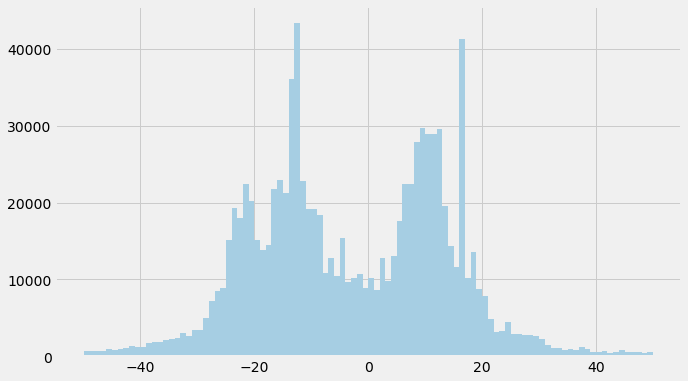

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(-50, 50), bins=100)
plt.show()

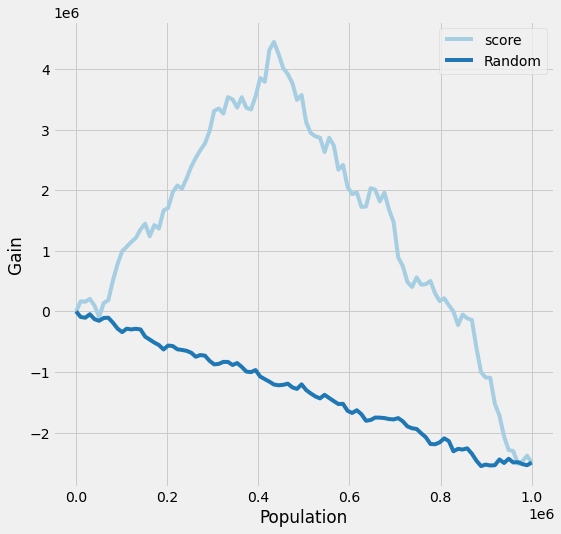

In [78]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [28]:
# N_USERS_OPTIM = 520000

In [29]:
_p_score_const = campaign_results.loc[:, col_treatment].value_counts(normalize=True).loc[1]
print(_p_score_const)
_p_scores = pd.Series(data=_p_score_const, index=campaign_results.index)

model_n1.fit(
    X=campaign_results.loc[:, cols_features].values,
    treatment=campaign_results.loc[:, col_treatment].values,
    y=campaign_results.loc[:, col_target].values,
    p=_p_scores
)

0.25


In [30]:
upmodel_rf = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='DDP',
    n_estimators=10,
#     max_features=40,
    max_depth=10,
    min_samples_leaf=200
)

In [31]:
# campaign_results = campaign_results.ffill()
# campaign_results = campaign_results.bfill()

In [32]:
%%time 


upmodel_rf.fit(
    X=campaign_results.loc[fit_index, cols_features].fillna(0).values,
    treatment=campaign_results.loc[fit_index, col_treatment].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=campaign_results.loc[fit_index, col_target].values,
)

invalid value encountered in sqrt


CPU times: user 22min 58s, sys: 1h 9min 18s, total: 1h 32min 16s
Wall time: 33min 15s


In [33]:
_eval_data = campaign_results.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = upmodel_rf.predict(_eval_data[cols_features].fillna(0).values)
_eval_data = _eval_data[['score', col_treatment, col_target]]

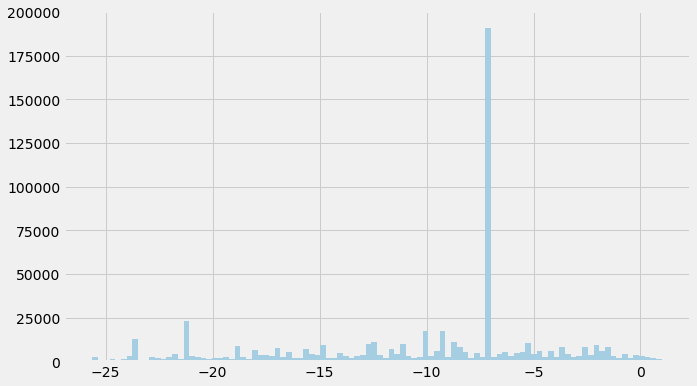

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(np.percentile(_eval_data['score'], 5), 1), bins=100)
plt.show()

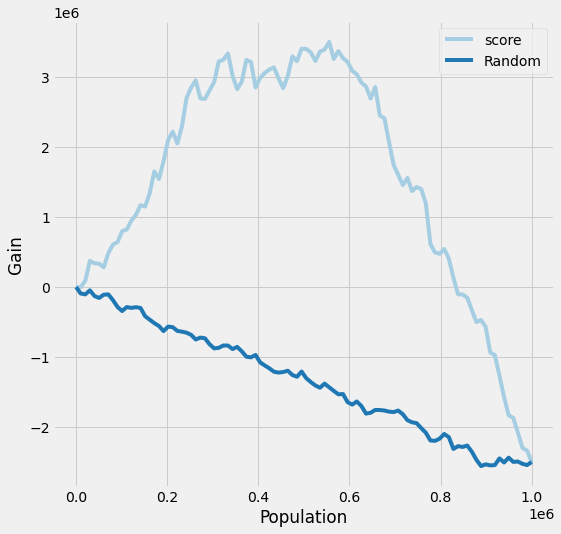

In [35]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [36]:
# N_USERS_OPTIM = 480000

In [79]:
df_test = _prepare_test_data(
    receipts,
    customers,
    TEST_DATE_TO,
)

df_test.shape

(2000000, 79)

In [38]:
# df_test = df_test.ffill()
# df_test = df_test.bfill()

In [39]:
# RandomForest
df_test['score'] = upmodel_rf.predict(df_test[cols_features].fillna(0)).reshape(-1)

In [80]:
df_test['score'] = model_n1.predict(df_test[cols_features])

In [81]:
# # R-learner
# df_test['score'] = model_n1.predict(df_test[cols_features]).reshape(-1)

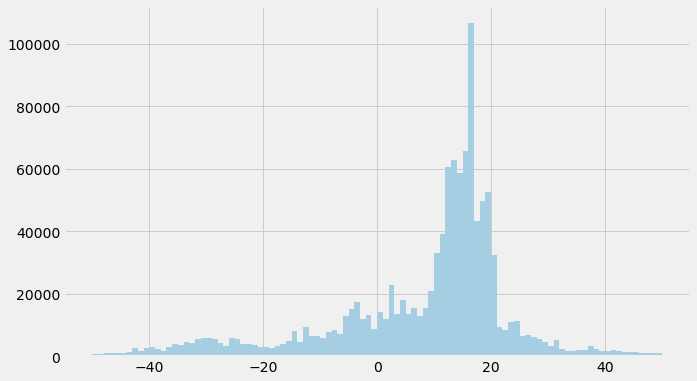

In [82]:
plt.figure(figsize=(10, 6))
plt.hist(df_test['score'], bins=100, range=(-50, 50))
plt.show()

In [83]:
(df_test['score'] > 5.0).mean()

0.730568

In [84]:
df_test[df_test['score'] > 5.0]['customer_id'].to_csv('submission_n1.csv',
                                                      index=None)

In [ ]:
df_test.sort_values(
    by='score', ascending=False).iloc[:N_USERS_OPTIM][['customer_id', 'score']]

In [ ]:
df_test = df_test.sort_values(
    by='score', ascending=False).iloc[:N_USERS_OPTIM][['customer_id']]

In [ ]:
df_test.to_csv('submit.csv', index=False)